# 🎈 Super Simple QTFT (Kid Edition) — Side‑by‑Side Forecasting (Polished)

**Goal:** Compare a tiny **Normal LSTM** vs a **Quantum‑flavored LSTM (“Magic Box”)** on a noisy time series.

**What you’ll see**
- Train/test loss curves
- A side‑by‑side forecast plot (true vs predictions)
- Final test losses for both models

**How to read results**
- Lower test loss = better generalization
- Prediction lines close to the blue **True** line = better forecasting


## 1) Switches (tweak and re‑run)
> Try: `EPOCHS=50`, `LR=0.02`, `NOISE=0.3`, `D_MODEL=24`, `LSTM_HIDDEN=12`

In [1]:
PAST_STEPS=10; FUTURE_STEPS=5; EPOCHS=30; LR=0.05; NOISE=0.20; N_SAMPLES=260; D_MODEL=16; LSTM_HIDDEN=8; PRINT_EVERY=5

## 2) Tools we need

In [2]:
import math, random
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F

SEED=1234; random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## 3) Make a tiny pretend world 🌍

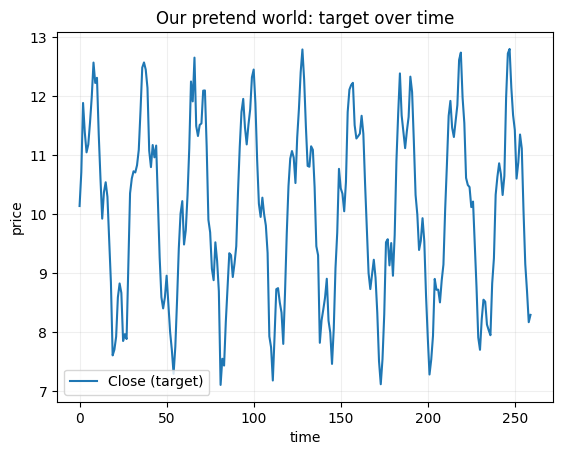

Features shape: (260, 4) | Target shape: (260,)


In [3]:
def make_synthetic(n=260, noise=0.2):
    t = np.arange(n)
    base = 10 + 2*np.sin(2*np.pi*t/30.0) + 0.7*np.sin(2*np.pi*t/7.0)
    y = base + noise*np.random.randn(n)
    Open = y + 0.05*np.random.randn(n)
    High = y + np.abs(0.2*np.random.randn(n))
    Low  = y - np.abs(0.2*np.random.randn(n))
    Last = y + 0.03*np.random.randn(n)
    Close= y + 0.04*np.random.randn(n)
    X = np.stack([Open, High, Low, Last], axis=1).astype(np.float32)
    return X, Close.astype(np.float32)

X, y = make_synthetic(N_SAMPLES, NOISE)
plt.figure(); plt.plot(y, label='Close (target)')
plt.title('Our pretend world: target over time'); plt.xlabel('time'); plt.ylabel('price')
plt.legend(); plt.grid(True, alpha=0.2); plt.show()
print('Features shape:', X.shape, '| Target shape:', y.shape)

## 4) Slice into stories (past → future) + scale

In [4]:
def minmax_scale(arr):
    mn, mx = arr.min(), arr.max()
    if mx - mn < 1e-8: return arr*0, (mn, mx)
    return (arr - mn) / (mx - mn), (mn, mx)
def minmax_unscale(arr, mm):
    mn, mx = mm; return arr*(mx-mn) + mn

X_scaled = X.copy().astype(np.float32); mm_X = []
for c in range(X.shape[1]):
    X_scaled[:,c], mmc = minmax_scale(X[:,c]); mm_X.append(mmc)
y_scaled, mm_y = minmax_scale(y.astype(np.float32))

def build_windows(Xa, ya, past, future):
    Xp, Xf, Y = [], [], []
    for t in range(past, len(Xa)-future):
        Xp.append(Xa[t-past:t])
        Xf.append(Xa[t:t+future])
        Y.append(ya[t:t+future])
    Xp = np.stack(Xp).astype(np.float32)
    Xf = np.stack(Xf).astype(np.float32)
    Y  = np.stack(Y).astype(np.float32)[..., None]
    return Xp, Xf, Y

Xp, Xf, Y = build_windows(X_scaled, y_scaled, PAST_STEPS, FUTURE_STEPS)
N = len(Xp); cut = int(0.7*N)
Xptr, Xftr, Ytr = torch.tensor(Xp[:cut]).to(device), torch.tensor(Xf[:cut]).to(device), torch.tensor(Y[:cut]).to(device)
Xpte, Xfte, Yte = torch.tensor(Xp[cut:]).to(device), torch.tensor(Xf[cut:]).to(device), torch.tensor(Y[cut:]).to(device)
print('Train shapes:', Xptr.shape, Xftr.shape, Ytr.shape)
print('Test  shapes:', Xpte.shape, Xfte.shape, Yte.shape)

Train shapes: torch.Size([171, 10, 4]) torch.Size([171, 5, 4]) torch.Size([171, 5, 1])
Test  shapes: torch.Size([74, 10, 4]) torch.Size([74, 5, 4]) torch.Size([74, 5, 1])


## 5) Models at a glance

**Normal Brain (LSTM):**
- Projects features → encodes past with LSTM → decodes future with LSTM → linear head.

**Magic Box Brain (Quantum‑flavored):**
- Same backbone as Normal, but inserts a “Magic Box”:
  - `sin/cos` encode → tiny mixing with gates → `tanh` readout
- This mimics a quantum layer’s encode → entangle → measure vibe (implemented in PyTorch only).


In [5]:
class NormalBrain(nn.Module):
    def __init__(self, n_features=4, d_model=16, lstm_hidden=8, future=5):
        super().__init__()
        self.var_proj = nn.Linear(n_features, d_model)
        self.enc = nn.LSTM(d_model, lstm_hidden, batch_first=True)
        self.dec = nn.LSTM(d_model, lstm_hidden, batch_first=True)
        self.up  = nn.Linear(lstm_hidden, d_model)
        self.head= nn.Linear(d_model, 1)
    def forward(self, Xp, Xf):
        xp = self.var_proj(Xp); xf = self.var_proj(Xf)
        _, (h, c) = self.enc(xp)
        dec_out, _ = self.dec(xf, (h, c))
        z  = self.up(dec_out)
        return self.head(z)

class MagicBox(nn.Module):
    def __init__(self, d_model=16):
        super().__init__()
        self.enc  = nn.Linear(d_model*2, d_model)
        self.mix1 = nn.Linear(d_model, d_model)
        self.mix2 = nn.Linear(d_model, d_model)
    def forward(self, x):
        s, c = torch.sin(x), torch.cos(x)
        h = torch.cat([s, c], dim=-1)
        h = F.elu(self.enc(h))
        g = torch.sigmoid(self.mix1(h))
        m = F.elu(self.mix2(h))
        z = g*m + (1-g)*h
        return torch.tanh(z)

class MagicBrain(nn.Module):
    def __init__(self, n_features=4, d_model=16, lstm_hidden=8, future=5):
        super().__init__()
        self.var_proj = nn.Linear(n_features, d_model)
        self.enc = nn.LSTM(d_model, lstm_hidden, batch_first=True)
        self.dec = nn.LSTM(d_model, lstm_hidden, batch_first=True)
        self.up  = nn.Linear(lstm_hidden, d_model)
        self.magic1 = MagicBox(d_model)
        self.magic2 = MagicBox(d_model)
        self.head= nn.Linear(d_model, 1)
    def forward(self, Xp, Xf):
        xp = self.var_proj(Xp); xf = self.var_proj(Xf)
        _, (h, c) = self.enc(xp)
        dec_out, _ = self.dec(xf, (h, c))
        z  = self.up(dec_out)
        z  = self.magic1(z); z  = self.magic2(z)
        return self.head(z)

## 6) Train both models

In [6]:
def mae_loss(y_true, y_pred): return torch.mean(torch.abs(y_true - y_pred))

def train(model, Xptr, Xftr, Ytr, Xpte, Xfte, Yte, epochs=30, lr=0.05, print_every=5):
    model.to(device); opt = torch.optim.Adam(model.parameters(), lr=lr)
    tr, te = [], []
    for ep in range(epochs):
        model.train(); opt.zero_grad()
        yhat = model(Xptr, Xftr); loss = mae_loss(Ytr, yhat)
        loss.backward(); opt.step(); tr.append(loss.item())
        model.eval()
        with torch.no_grad():
            yhat_te = model(Xpte, Xfte)
            te.append(mae_loss(Yte, yhat_te).item())
        if (ep+1) % print_every == 0 or ep == 0:
            print(f"Epoch {ep+1:3d} | train {tr[-1]:.4f} | test {te[-1]:.4f}")
    return tr, te, model

torch.manual_seed(5678)
c_model=NormalBrain(d_model=D_MODEL, lstm_hidden=LSTM_HIDDEN, future=FUTURE_STEPS).to(device)
m_model=MagicBrain(d_model=D_MODEL, lstm_hidden=LSTM_HIDDEN, future=FUTURE_STEPS).to(device)
tr_c, te_c, c_model = train(c_model, Xptr, Xftr, Ytr, Xpte, Xfte, Yte, epochs=EPOCHS, lr=LR, print_every=PRINT_EVERY)
tr_m, te_m, m_model = train(m_model, Xptr, Xftr, Ytr, Xpte, Xfte, Yte, epochs=EPOCHS, lr=LR, print_every=PRINT_EVERY)

Epoch   1 | train 0.3295 | test 0.3259
Epoch   5 | train 0.2048 | test 0.2015
Epoch  10 | train 0.1793 | test 0.1428
Epoch  15 | train 0.1082 | test 0.0909
Epoch  20 | train 0.0899 | test 0.0545
Epoch  25 | train 0.0605 | test 0.0554
Epoch  30 | train 0.0488 | test 0.0356
Epoch   1 | train 0.6220 | test 0.6466
Epoch   5 | train 0.2418 | test 0.2284
Epoch  10 | train 0.2345 | test 0.2230
Epoch  15 | train 0.2240 | test 0.2193
Epoch  20 | train 0.1010 | test 0.3380
Epoch  25 | train 0.1006 | test 0.0718
Epoch  30 | train 0.0472 | test 0.3042


## 7) Learning curves

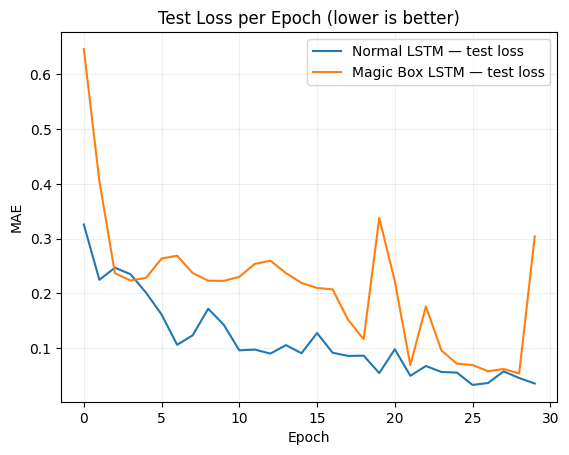

Final test loss — Normal LSTM: 0.0356
Final test loss — Magic Box   : 0.3042


In [7]:
plt.figure()
plt.plot(te_c, label='Normal LSTM — test loss')
plt.plot(te_m, label='Magic Box LSTM — test loss')
plt.title('Test Loss per Epoch (lower is better)')
plt.xlabel('Epoch'); plt.ylabel('MAE'); plt.legend(); plt.grid(True, alpha=0.2); plt.show()
print(f"Final test loss — Normal LSTM: {te_c[-1]:.4f}")
print(f"Final test loss — Magic Box   : {te_m[-1]:.4f}")

## 8) One forecast horizon (true vs predictions) + save preview

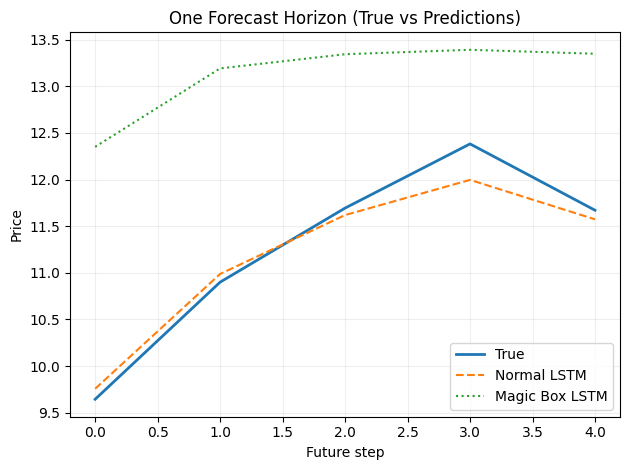

✅ Quick verdict on this run: Normal LSTM achieved the lower final test loss.
Saved preview.png (upload to imgs/preview.png in your repo).


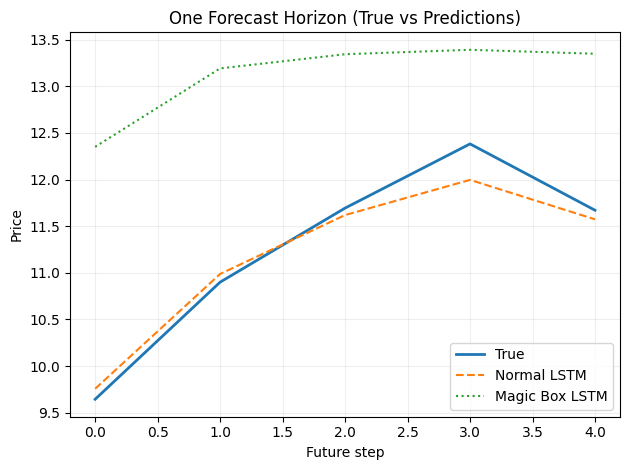

In [8]:
with torch.no_grad():
    yhat_c = c_model(Xpte[:1], Xfte[:1]).cpu().numpy()[0,:,0]
    yhat_m = m_model(Xpte[:1], Xfte[:1]).cpu().numpy()[0,:,0]
true = Yte[:1].cpu().numpy()[0,:,0]

def unscale_y(a): return minmax_unscale(a, mm_y)

true_i = unscale_y(true); pred_c = unscale_y(yhat_c); pred_m = unscale_y(yhat_m)

plt.figure()
plt.plot(true_i, label='True', linewidth=2)
plt.plot(pred_c, '--', label='Normal LSTM')
plt.plot(pred_m, ':',  label='Magic Box LSTM')
plt.title('One Forecast Horizon (True vs Predictions)'); plt.xlabel('Future step'); plt.ylabel('Price')
plt.legend(); plt.grid(True, alpha=0.2); plt.tight_layout(); plt.show()

best = "Normal LSTM" if te_c[-1] <= te_m[-1] else "Magic Box LSTM"
print(f"✅ Quick verdict on this run: {best} achieved the lower final test loss.")

plt.figure()
plt.plot(true_i, label='True', linewidth=2)
plt.plot(pred_c, '--', label='Normal LSTM')
plt.plot(pred_m, ':',  label='Magic Box LSTM')
plt.title('One Forecast Horizon (True vs Predictions)'); plt.xlabel('Future step'); plt.ylabel('Price')
plt.legend(); plt.grid(True, alpha=0.2); plt.tight_layout()
plt.savefig('preview.png', dpi=180)
print("Saved preview.png (upload to imgs/preview.png in your repo).")

## 9) Results summary

- **Final test loss (lower is better)** — printed above for each model.
- In the forecast plot, the best model’s line should follow the blue **True** line more closely.

> Because the data is noisy and the models are tiny, results can vary. Try: more epochs (50–100), lower LR (0.02), or bigger models (`D_MODEL=24`, `LSTM_HIDDEN=12`).